In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from skimage import color
import numpy as np
import os, time, pickle, json 
from glob import glob 
from PIL import Image
import cv2 
from typing import List, Tuple, Dict
from statistics import mean 
import torch.nn.functional as F
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader
import pickle

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(3, 256, 256)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.figure(figsize=(15, 15), dpi=80)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def crop(image, new_shape):
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels (assumes that the input's size and the new size are
    even numbers).
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    cropped_image = image[:, :, starting_height:final_height, starting_width:final_width]
    return cropped_image

class ContractingBlock(nn.Module):
    '''

    
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ContractingBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels * 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(input_channels * 2, input_channels * 2, kernel_size=3, padding=1)
        self.activation = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels * 2)
        self.use_bn = use_bn
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class:
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions with optional dropout
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, use_dropout=False, use_bn=True):
        super(ExpandingBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=2, padding=1)
        if use_bn:
            self.batchnorm = nn.BatchNorm2d(input_channels // 2)
        self.use_bn = use_bn
        self.activation = nn.ReLU()
        if use_dropout:
            self.dropout = nn.Dropout()
        self.use_dropout = use_dropout

    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        x = self.conv3(x)
        if self.use_bn:
            x = self.batchnorm(x)
        if self.use_dropout:
            x = self.dropout(x)
        x = self.activation(x)
        return x

class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a U-Net - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

class UNet(nn.Module):
    '''
    U-Net
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=32):
        super(UNet, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_dropout=True)
        self.contract2 = ContractingBlock(hidden_channels * 2, use_dropout=True)
        self.contract3 = ContractingBlock(hidden_channels * 4, use_dropout=True)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.contract5 = ContractingBlock(hidden_channels * 16)
        self.contract6 = ContractingBlock(hidden_channels * 32)
        self.expand0 = ExpandingBlock(hidden_channels * 64)
        self.expand1 = ExpandingBlock(hidden_channels * 32)
        self.expand2 = ExpandingBlock(hidden_channels * 16)
        self.expand3 = ExpandingBlock(hidden_channels * 8)
        self.expand4 = ExpandingBlock(hidden_channels * 4)
        self.expand5 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.contract5(x4)
        x6 = self.contract6(x5)
        x7 = self.expand0(x6, x5)
        x8 = self.expand1(x7, x4)
        x9 = self.expand2(x8, x3)
        x10 = self.expand3(x9, x2)
        x11 = self.expand4(x10, x1)
        x12 = self.expand5(x11, x0)
        xn = self.downfeature(x12)
        return self.sigmoid(xn)

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator 
    Parameters:
        input_channels: the number of image input channels
        hidden_channels: the initial number of discriminator convolutional filters
    '''
    def __init__(self, input_channels, hidden_channels=8):
        super(Discriminator, self).__init__()
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels, use_bn=False)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.final = nn.Conv2d(hidden_channels * 16, 1, kernel_size=1)

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        xn = self.final(x4)
        return xn

In [ ]:
dataset = []
with open(r"/content/drive/MyDrive/ai4good/val.pkl", "rb") as file:
  dataset = pickle.load(file)

In [ ]:
dataset = []
with open(r"/content/drive/MyDrive/ai4good/train3.pkl", "rb") as file:
  dataset = pickle.load(file)

#Sanity Checks


In [ ]:
adv_criterion = nn.BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
#this parameter tunes the pixel to pixel loss's weight
#see crit loss above to understand
lambda_recon = 800

n_epochs = 3
input_dim = 3
out_dim = 1
display_step = 100
batch_size = 128
lr = 0.0001
target_shape = 256

MEAN = (0.5, 0.5, 0.5,)
STD = (0.5, 0.5, 0.5,)
SIZE = 256



class Transform():
    def __init__(self, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([ 
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        
    def __call__(self, img: Image.Image):
        return self.data_transform(img)

class MaskTransform():
    def __init__(self, mean=MEAN, std=STD):
        self.data_transform = transforms.Compose([ 
            transforms.ToTensor()
        ])
        
    def __call__(self, img: Image.Image):
        return self.data_transform(img)

    
class Dataset(object):
    def __init__(self, data):
        self.data = data 
        self.transformer = Transform()
        self.mask_transform = MaskTransform()
        
    
    def __getitem__(self, idx: int):
        image, mask = self.data[idx]
        image = self.transformer(image)
        mask = self.mask_transform(mask)
        return image, mask
    
    def __len__(self):
        return len(self.data)

In [ ]:
class Dataset_read(object):
    def __init__(self, data):
        self.data = data 
        self.transformer = Transform()
        self.mask_transform = Transform(0.5, 0.5)
        
    
    def __getitem__(self, idx: int):
        image, mask = self.data[idx]
        image = Image.open(image)
        mask = Image.open(mask)
        image = self.transformer(image)
        mask = self.mask_transform(mask)
        return image, mask
    
    def __len__(self):
        return len(self.data)

In [ ]:
val_ds = Dataset(dataset)

In [ ]:
len(val_ds)

17375

In [ ]:
#uncomment if not loading old model
gen = UNet(3, 1).to(device)
#gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
#disc = Discriminator(input_dim + out_dim).to(device)
#disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
#uncomment only if start new training
#gen = gen.apply(weights_init)
#disc = disc.apply(weights_init)


In [ ]:
gen.load_state_dict(torch.load('/content/drive/MyDrive/ai4good/pix2pixgen_bldgs.pth'))
#disc.load_state_dict(torch.load('/content/drive/MyDrive/ai4good/pix2pixdiscsafety199.pth'), map_location = torch.device('cpu'))

<All keys matched successfully>

In [ ]:
def get_gen_loss(gen, mask, image, adv_criterion, recon_criterion, lambda_recon):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator; takes the condition and returns potential images
        mask: the mask images (e.g. maps) to be used to evaluate the reconstruction
        image: the satellite images) which are used to produce the masks
        adv_criterion: the adversarial loss function; takes the discriminator 
        predictions and the true labels and returns a adversarial loss 
        recon_criterion: the reconstruction loss function; takes the generator 
        outputs and the masks and returns a reconstruction loss 
        lambda_recon: the degree to which the reconstruction loss should be weighted in the sum
        removed disc to save memory, adds only just about 1 anyway
        #found higher to be better pix2pix used 200
    '''
    fake = gen(image)
    gen_rec_loss = recon_criterion(mask, fake)
    gen_loss = lambda_recon * gen_rec_loss
    return gen_loss

In [ ]:
def eval():
    preds = []
    masks = []
    images = []
    mean_generator_loss = 0
    dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)
    cur_step = 0

    for image, mask in tqdm(dataloader):
        cur_batch_size = len(mask)
        
        mask = mask.to(device)
        image = image.to(device)


        fake_map = gen(image)
        preds.append(fake_map.cpu().detach().numpy())
        masks.append(mask.cpu().detach().numpy())
        images.append(image.cpu().numpy())
        gen_loss = get_gen_loss(gen, mask, image, adv_criterion, recon_criterion, 1000)
        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0:
            if cur_step > 0:
                print(f"Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}")
            show_tensor_images(image, size=(input_dim, target_shape, target_shape))
            show_tensor_images(mask, size=(out_dim, target_shape, target_shape))
            show_tensor_images(fake_map, size=(out_dim, target_shape, target_shape))
            mean_generator_loss = 0
        cur_step += 1
        break
    return preds, images, masks

  0%|          | 0/136 [00:00<?, ?it/s]

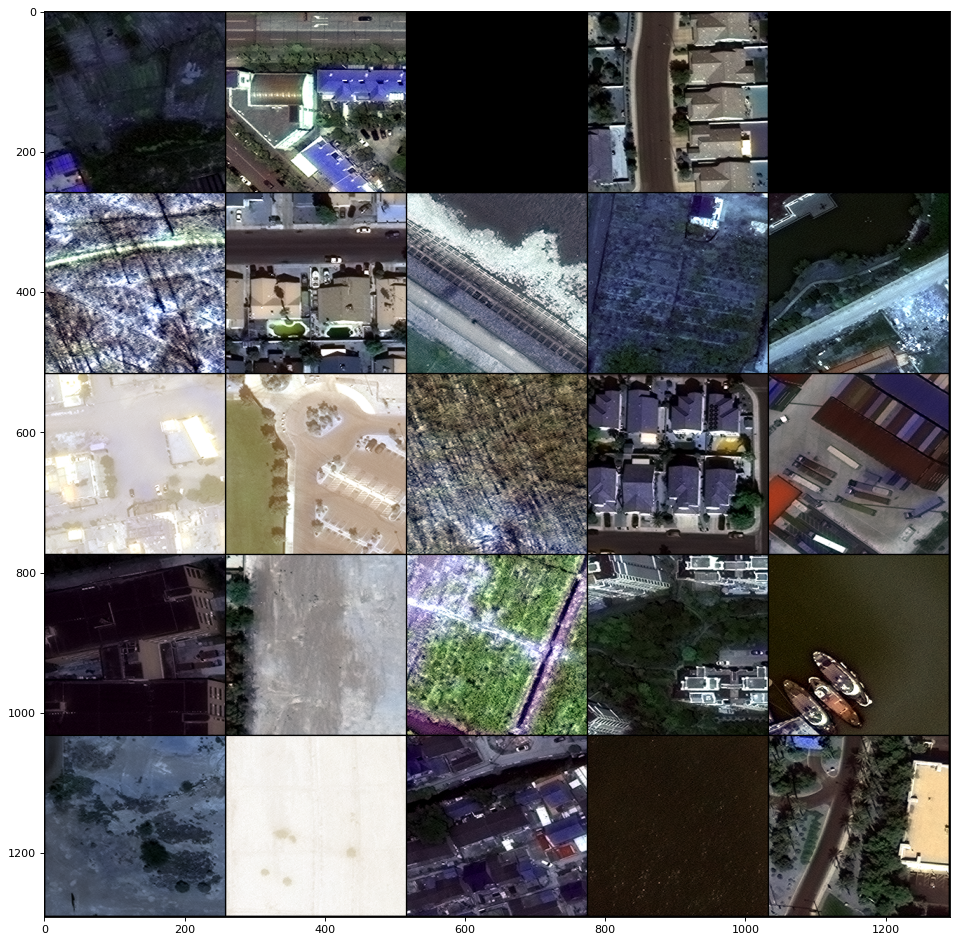

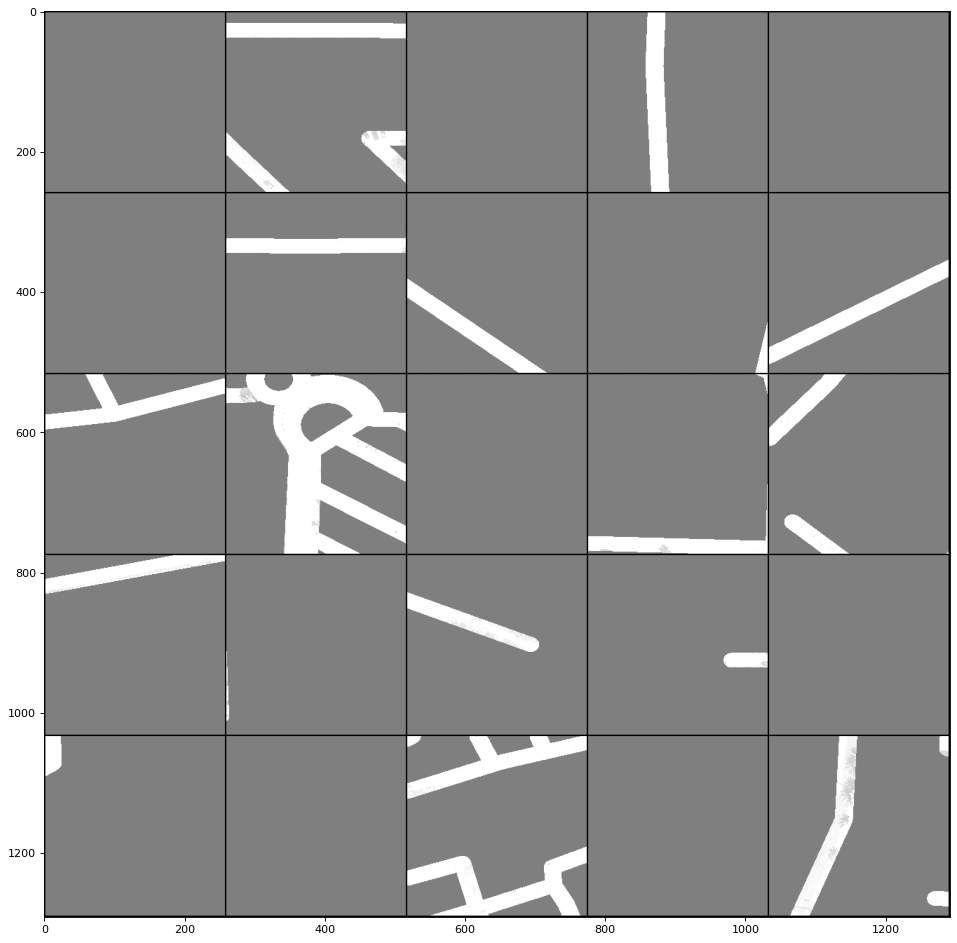

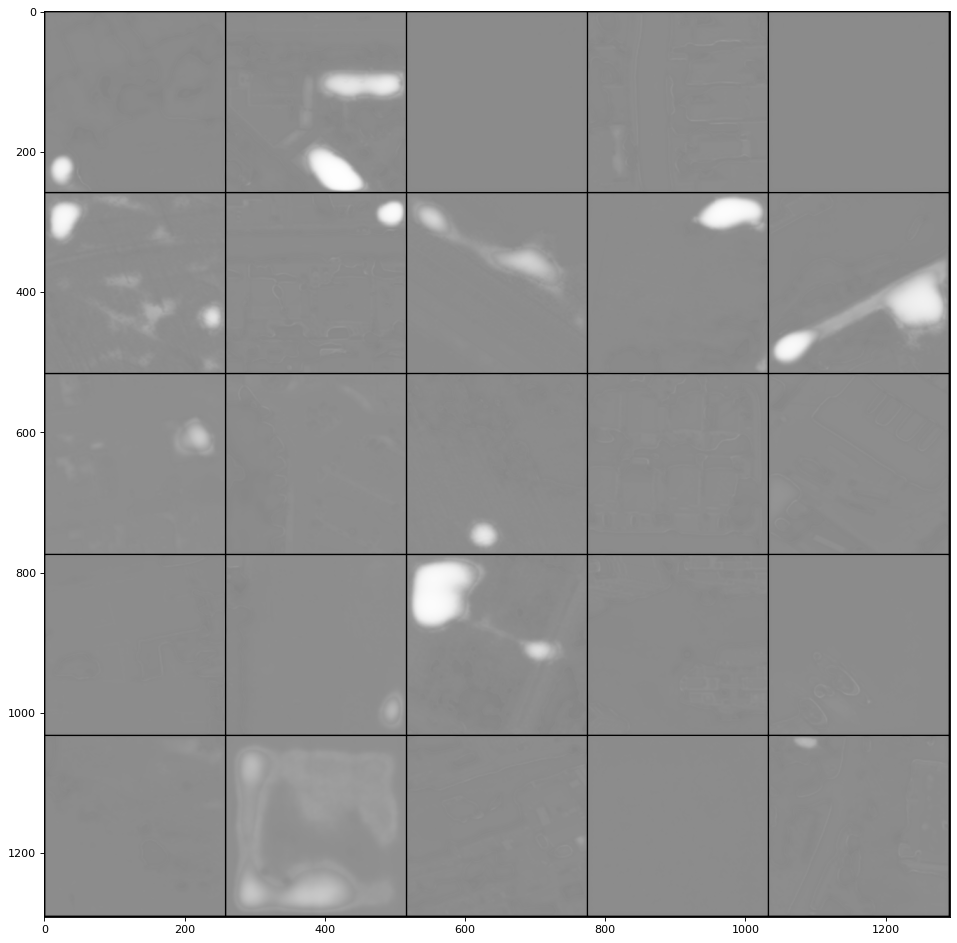

In [ ]:
with torch.no_grad():
  preds, images, masks = eval()

In [ ]:
preds[0][1]

array([[[0.1129378 , 0.09417964, 0.0930846 , ..., 0.09087406,
         0.10360762, 0.09375176],
        [0.10755759, 0.08573896, 0.10196885, ..., 0.09123323,
         0.10650819, 0.10592303],
        [0.10079505, 0.09642479, 0.08443463, ..., 0.08680571,
         0.08919597, 0.09250253],
        ...,
        [0.09068915, 0.09805736, 0.10093302, ..., 0.07407559,
         0.06855758, 0.09798037],
        [0.10265239, 0.09988665, 0.09556236, ..., 0.05987447,
         0.05912039, 0.09357921],
        [0.09826122, 0.10134003, 0.08923925, ..., 0.09850583,
         0.10037331, 0.12147915]]], dtype=float32)

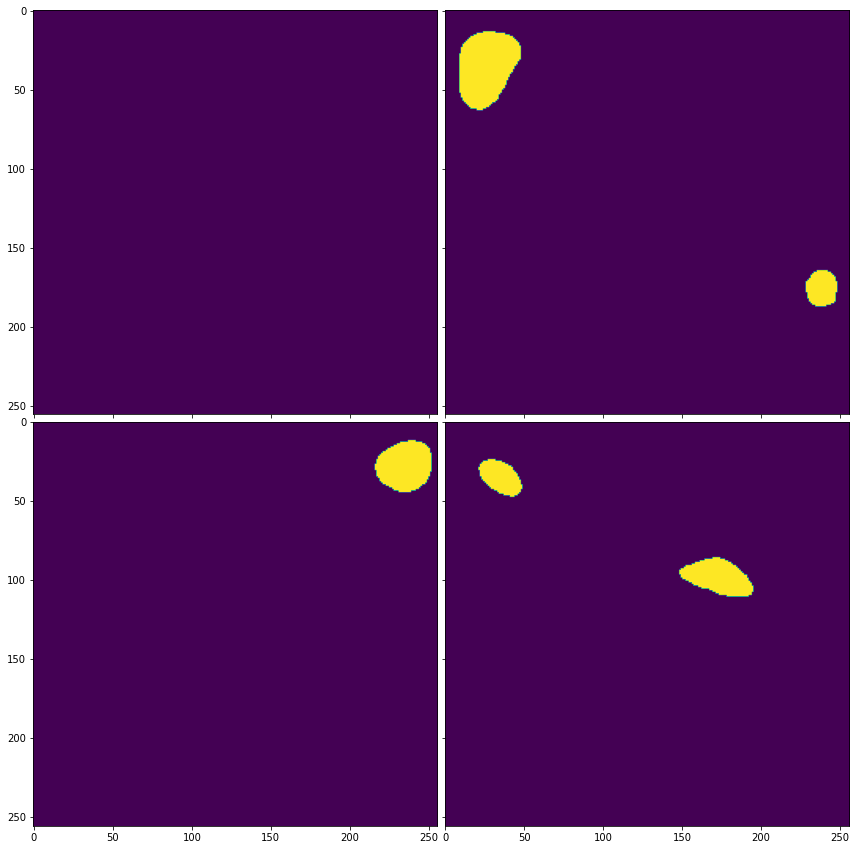

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
th = preds[0]
th[preds[0] <= 0.5] = 0
th[preds[0] > 0.5] = 1
for i, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.squeeze(th[i+4]))

plt.show()

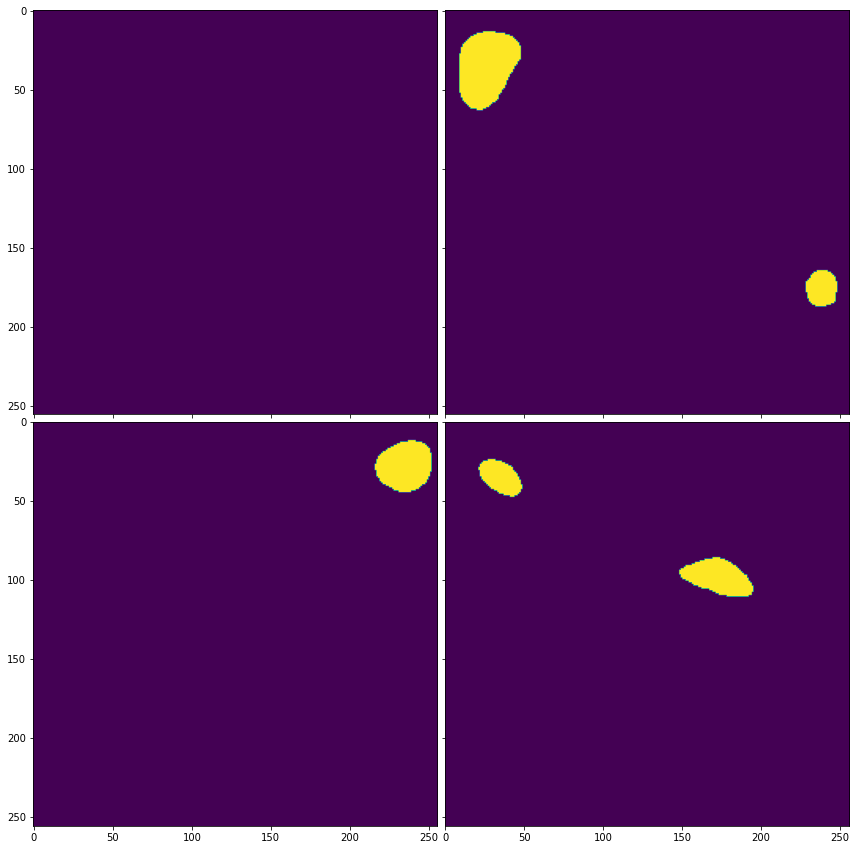

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
th = preds[0]
th[preds[0] < 0.01] = 0
for i, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.squeeze(th[i+4]))

plt.show()

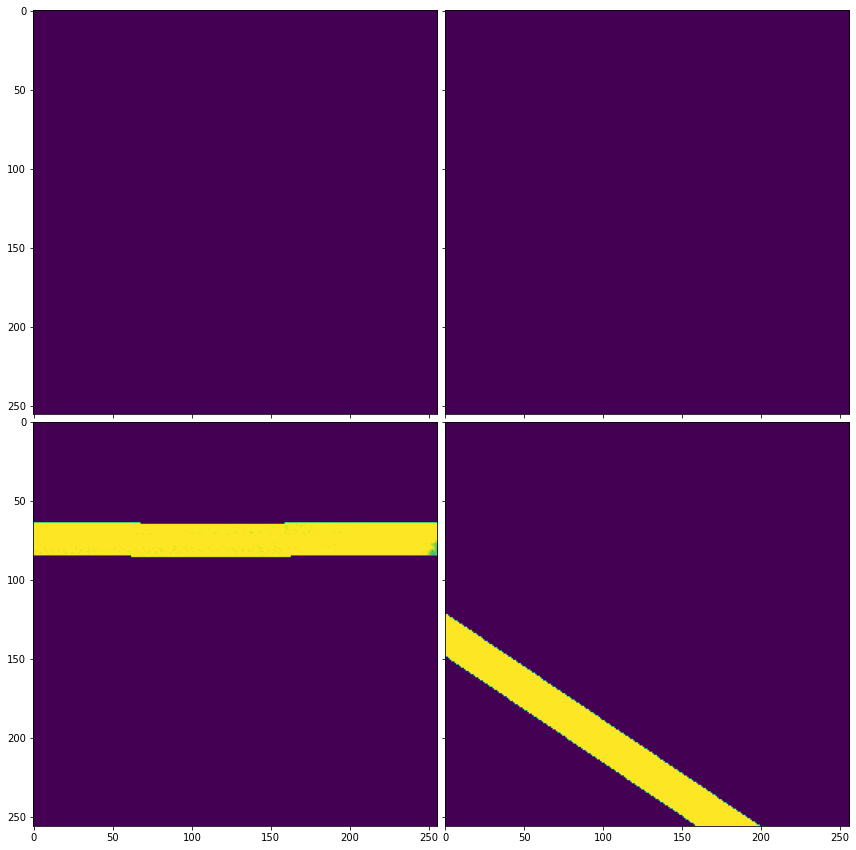

In [ ]:
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
mask = masks[0]
for i, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.squeeze(mask[i+4]))

plt.show()

In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        for t, m, s in zip(image, self.mean, self.std):
            t*s + m
        return image

NameError: ignored

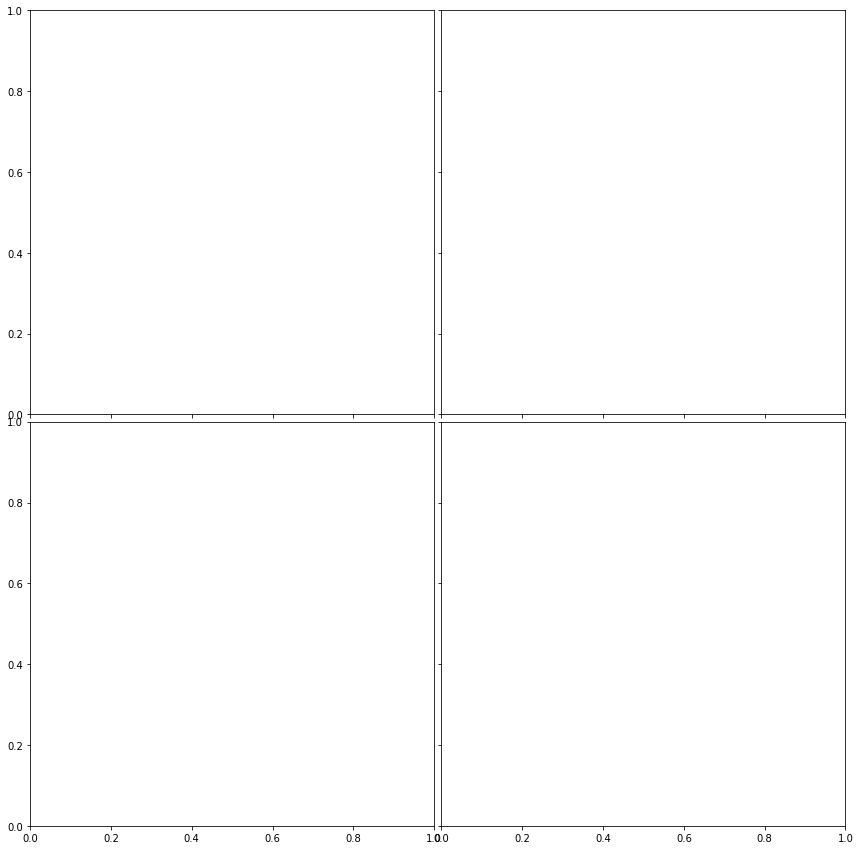

In [ ]:
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
image = images[0]
image = image.transpose((0, 2,3,1))
unorm = UnNormalize(mean=MEAN, std=STD)
image = unorm(image)
for i, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    show = image[i+16]
    ax.imshow(show.astype(np.int))

plt.show()

In [ ]:
transforms.Normalize(image, ())

In [ ]:
def preds_to_binary(pred_arr, channel_scaling=None, bg_threshold=0.1):
    """Convert a set of predictions from a neural net to a binary mask.
    Arguments
    ---------
    pred_arr : :class:`numpy.ndarray`
        4D array. in shape (batch_size, channel, width, height)
    channel_scaling : `list`-like of `float`s, optional
        The following operation will be performed to convert the
        multi-channel prediction to a 2D output ::
            sum(pred_arr[channel]*channel_scaling[channel])
        If not provided, no scaling will be performend and channels will be
        summed.
    bg_threshold : `int` or `float`, optional
        The cutoff to set to distinguish between background and foreground
        pixels in the final binary mask. Binarization takes place *after*
        channel scaling and summation (if applicable). Defaults to 0.
    Returns
    -------
    mask_arr : :class:`numpy.ndarray`
        A 2D boolean ``numpy`` array with ``True`` for foreground pixels and
        ``False`` for background.
    """
    #if pred_arr.shape[1] < pred_arr.shape[-1]:
    #  pred_arr = pred_arr.transpose(1,2,0)
        # if scale values weren't provided, nothing to do
    if channel_scaling is not None:  
      pred_arr = np.sum(pred_arr*np.array(channel_scaling), axis=-1)

    mask_arr = (pred_arr > bg_threshold).astype('uint8')

    return mask_arr*255

In [ ]:
def mask_to_poly_geojson(pred_arr, 
                         channel_scaling=None,
                         reference_im=None,
                         output_path=None,
                         output_type='geojson',
                         min_area=40,
                         bg_threshold=0,
                         do_transform=None,
                         simplify=False,
                         tolerance=0.5,
                         **kwargs):
    """Get polygons from an image mask.
    Arguments
    ---------
    pred_arr : :class:`numpy.ndarray`
        A 2D array of integers. Multi-channel masks are not supported, and must
        be simplified before passing to this function. Can also pass an image
        file path here.
    channel_scaling : :class:`list`-like, optional
        If `pred_arr` is a 3D array, this argument defines how each channel
        will be combined to generate a binary output. channel_scaling should
        be a `list`-like of length equal to the number of channels in
        `pred_arr`. The following operation will be performed to convert the
        multi-channel prediction to a 2D output ::
            sum(pred_arr[channel]*channel_scaling[channel])
        If not provided, no scaling will be performend and channels will be
        summed.
    reference_im : str, optional
        The path to a reference geotiff to use for georeferencing the polygons
        in the mask. Required if saving to a GeoJSON (see the ``output_type``
        argument), otherwise only required if ``do_transform=True``.
    output_path : str, optional
        Path to save the output file to. If not provided, no file is saved.
    output_type : ``'csv'`` or ``'geojson'``, optional
        If ``output_path`` is provided, this argument defines what type of file
        will be generated - a CSV (``output_type='csv'``) or a geojson
        (``output_type='geojson'``).
    min_area : int, optional
        The minimum area of a polygon to retain. Filtering is done AFTER
        any coordinate transformation, and therefore will be in destination
        units.
    bg_threshold : int, optional
        The cutoff in ``mask_arr`` that denotes background (non-object).
        Defaults to ``0``.
    simplify : bool, optional
        If ``True``, will use the Douglas-Peucker algorithm to simplify edges,
        saving memory and processing time later. Defaults to ``False``.
    tolerance : float, optional
        The tolerance value to use for simplification with the Douglas-Peucker
        algorithm. Defaults to ``0.5``. Only has an effect if
        ``simplify=True``.
    Returns
    -------
    gdf : :class:`geopandas.GeoDataFrame`
        A GeoDataFrame of polygons.
    """

    mask_arr = preds_to_binary(pred_arr, channel_scaling, bg_threshold)

    if do_transform and reference_im is None:
        raise ValueError(
            'Coordinate transformation requires a reference image.')

    if do_transform:
        with rasterio.open(reference_im) as ref:
            transform = ref.transform
            crs = ref.crs
            ref.close()
    else:
        transform = Affine(1, 0, 0, 0, 1, 0)  # identity transform
        crs = rasterio.crs.CRS()

    mask = mask_arr > bg_threshold
    mask = mask.astype('uint8')

    polygon_generator = features.shapes(mask_arr,
                                        transform=transform,
                                        mask=mask)
    polygons = []
    values = []  # pixel values for the polygon in mask_arr
    for polygon, value in polygon_generator:
        p = shape(polygon).buffer(0.0)
        if p.area >= min_area:
            polygons.append(shape(polygon).buffer(0.0))
            values.append(value)

    polygon_gdf = gpd.GeoDataFrame({'geometry': polygons, 'value': values},
                                   crs=crs.to_wkt())
    if simplify:
        polygon_gdf['geometry'] = polygon_gdf['geometry'].apply(
            lambda x: x.simplify(tolerance=tolerance)
        )
    # save output files
    if output_path is not None:
        if output_type.lower() == 'geojson':
            if len(polygon_gdf) > 0:
                polygon_gdf.to_file(output_path, driver='GeoJSON')
            else:
                save_empty_geojson(output_path, polygon_gdf.crs.to_epsg())
        elif output_type.lower() == 'csv':
            polygon_gdf.to_csv(output_path, index=False)

    return polygon_gdf

In [ ]:
test_arr = preds_to_binary(np.squeeze(preds[0]), bg_threshold=0.025)

In [ ]:
preds[0].shape

(128, 1, 256, 256)

In [ ]:
!pip install affine geopandas rasterio

     |████████████████████████████████| 1.0 MB 3.1 MB/s 
     |████████████████████████████████| 19.3 MB 161 kB/s 
     |████████████████████████████████| 15.4 MB 89.4 MB/s 
     |████████████████████████████████| 6.3 MB 22.5 MB/s 


In [ ]:
from affine import Affine
import rasterio
from rasterio import features
from shapely.geometry import shape
import geopandas as gpd

In [ ]:
test_gdf = mask_to_poly_geojson(np.squeeze(preds[0][0]), bg_threshold=0.025, simplify = True)

In [ ]:
test_arr.min()

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


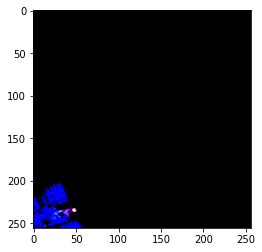

In [ ]:
plt.imshow(images[0][0].transpose((1,2,0))*5)

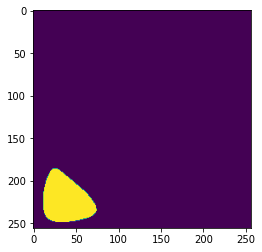

In [ ]:
plt.imshow(test_arr[99])

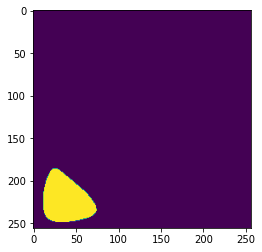

In [ ]:
plt.imshow(preds[0][99, 0, :, :])

In [ ]:
preds[0][99].mean()

0.041748047

In [ ]:
test_gdf.head()

,geometry,value
0,"POLYGON ((21.000 207.000, 21.000 208.000, 17.0...",255.0


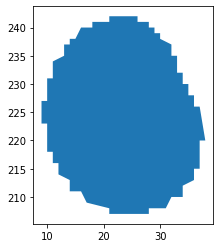

In [ ]:
test_gdf.plot()

In [ ]:
!pip install sknw

  Created wheel for sknw: filename=sknw-0.14-py3-none-any.whl size=3382 sha256=03c9f0ac1568090ea780be0a557e4faf7a671589a5fd0401ff898ff90c41d8c0
  Stored in directory: /root/.cache/pip/wheels/ca/bf/7b/5029002abec61d97b957427f4fd20426707486d99542feb85d
Successfully built sknw


In [ ]:
import sknw
from skimage.morphology import skeletonize

In [ ]:
test_arr[99][test_arr[99] > 0]

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [ ]:
ske = skeletonize(test_arr[99] / 255.0).astype(np.uint16)

In [ ]:
graph = sknw.build_sknw(ske)

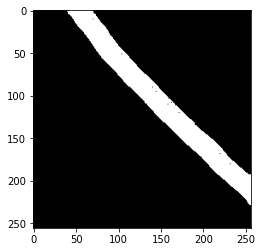

In [ ]:
plt.imshow(test_arr[99], cmap='gray')

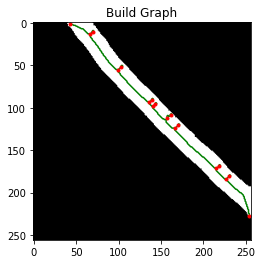

In [ ]:
plt.imshow(test_arr[99], cmap='gray')
# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')

# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()

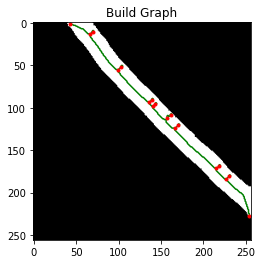

In [ ]:
ske = skeletonize(test_arr[99] / 255.0).astype(np.uint16)
graph = sknw.build_sknw(ske)
plt.imshow(test_arr[99], cmap='gray')
# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')

# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()

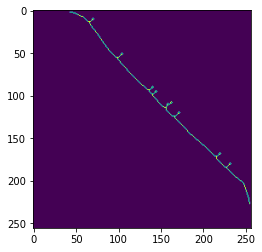

In [ ]:
plt.imshow(ske)

In [ ]:
from skimage.morphology import skeletonize
from skimage import data
import sknw

# open and skeletonize
img = data.horse()
ske = skeletonize(~img).astype(np.uint16)

# build graph from skeleton
graph = sknw.build_sknw(ske)

# draw image
plt.imshow(img, cmap='gray')

# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'green')
    
# draw node by o
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')

# title and show
plt.title('Build Graph')
plt.show()

In [ ]:
plt.imshow(data.horse())

In [ ]:
data.horse()